In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import datetime

from datetime import timedelta, date
import time
import os

import warnings
warnings.filterwarnings('ignore')

import numpyro
import numpyro.distributions as dist

import arviz as az
import jax.numpy as jnp
import jax.random as random
from numpyro.infer import MCMC, NUTS, Predictive
import graphviz


import sys
sys.path.append('../../../filecoin-mecha-twin/')

from mechafil.data import get_historical_network_stats, \
    get_sector_expiration_stats, \
    query_starboard_supply_stats, \
    get_day_renewed_qa_power_stats, \
    query_starboard_sector_expirations
from mechafil.power import forecast_power_stats, build_full_power_stats_df
from mechafil.vesting import compute_vesting_trajectory_df
from mechafil.minting import compute_minting_trajectory_df
from mechafil.supply import forecast_circulating_supply_df

# Renewal rate

In [13]:
today = '2022-11-19'

df_renewal_rate_orig = pd.read_csv('offline_info/Scheduled_Expiration_by_Date_Breakdown_in_PiB.csv')
df_renewal_rate = df_renewal_rate_orig.copy()
df_renewal_rate = df_renewal_rate[df_renewal_rate.stateTime <= today]

df_renewal_rate['Renewal_Rate'] = df_renewal_rate['Extend'] / (df_renewal_rate['Extend'] 
                             + df_renewal_rate['Expired']
                             + df_renewal_rate['Potential Expire'] 
                             + df_renewal_rate['Terminate'])

SECTOR_PER_PIB = 1024 / 32
df_renewal_rate['Extend_32GiB_sectors'] = df_renewal_rate['Extend'] / SECTOR_PER_PIB
df_renewal_rate['Expired_32GiB_sectors'] = df_renewal_rate['Expired'] / SECTOR_PER_PIB
df_renewal_rate['Pot_Expired_32GiB_sectors'] = df_renewal_rate['Potential Expire'] / SECTOR_PER_PIB
df_renewal_rate['Terminate_32GiB_sectors'] = df_renewal_rate['Terminate'] / SECTOR_PER_PIB

In [14]:
df_renewal_rate

,stateTime,Extend,Expired,Potential Expire,Terminate,Renewal_Rate,Extend_32GiB_sectors,Expired_32GiB_sectors,Pot_Expired_32GiB_sectors,Terminate_32GiB_sectors
0,2022-05-25,14.68,8.35,0.00,0.05,0.636049,0.458750,0.260937,0.000000,0.001563
1,2022-05-26,14.14,7.95,0.00,0.03,0.639241,0.441875,0.248438,0.000000,0.000937
2,2022-05-27,14.70,8.45,0.00,0.04,0.633894,0.459375,0.264062,0.000000,0.001250
3,2022-05-28,14.78,6.46,0.00,0.03,0.694875,0.461875,0.201875,0.000000,0.000937
4,2022-05-29,17.92,9.57,0.00,0.04,0.650926,0.560000,0.299063,0.000000,0.001250
...,...,...,...,...,...,...,...,...,...,...
174,2022-11-15,36.67,16.98,-0.71,0.96,0.680334,1.145938,0.530625,-0.022187,0.030000
175,2022-11-16,30.77,18.30,-0.66,0.95,0.623379,0.961562,0.571875,-0.020625,0.029687
176,2022-11-17,34.72,21.57,-0.81,1.21,0.612454,1.085000,0.674063,-0.025313,0.037812
177,2022-11-18,31.73,18.03,-0.57,0.86,0.633966,0.991563,0.563438,-0.017812,0.026875


<AxesSubplot:>

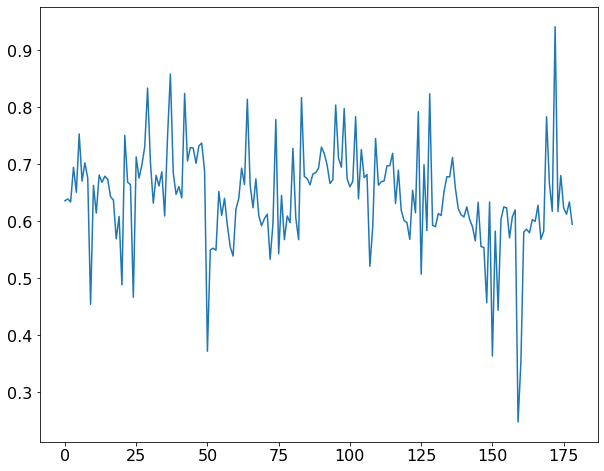

In [15]:
df_renewal_rate.Renewal_Rate.plot()

### Extensions

In [16]:
def model2(y=None, x=None, periodicity=14):
    
    step_sigma = numpyro.sample("sigma_step", dist.Exponential(1.0))
    step_mu = numpyro.sample("mu_step", dist.Exponential(1.0))
    
    sigma = numpyro.sample(
        "sigma", dist.GaussianRandomWalk(scale=step_sigma, num_steps=jnp.shape(x)[0])
    )
    weeks = x.shape[0] // periodicity
    mu = numpyro.sample(
        "mu", dist.GaussianRandomWalk(scale=step_mu, num_steps=weeks)
    )
    mu = jnp.repeat(mu, periodicity)
    mu = jnp.append(mu, jnp.repeat(mu[-1], (jnp.shape(x)[0] % periodicity)))
    numpyro.sample("obs", dist.LogNormal(loc=mu, scale=jnp.exp(sigma)), obs=y)
    
def run_model(x,y,periodicity=14):
    mcmc = MCMC(
            NUTS(model2), 
            num_warmup=2000, num_samples=1000)
    mcmc.run(random.PRNGKey(0), y=y, x=x, periodicity=periodicity)
    samples = mcmc.get_samples()
    rng_key = random.PRNGKey(0)

    mcmc.print_summary()
    
    rng_key = random.PRNGKey(0)
    predictive = Predictive(model2, samples)
    predictions = predictive(rng_key, x=x,periodicity=periodicity)["obs"]
    
    return mcmc, predictions

def plt_posteriors(predictions, title="Terminations"):
    plt.rcParams.update({'font.size': 16})
    plt.rcParams['figure.figsize'] = [10, 8]
    pred_q = jnp.quantile(predictions, q=np.array([0.05,0.95]), axis=0)
    pred_mu = jnp.mean(predictions, axis=0)
    x_vals = np.arange(0,len(pred_q[0]))
    plt.fill_between(x_vals, pred_q[0], pred_q[1], alpha=0.3, interpolate=True,label="Fit")
    # plt.plot(x_vals, pred_mu, label="Fit")
    plt.scatter(x_vals, y, s=15, color='orange', label="Fitting data")
    plt.title(title)
    plt.legend()

    plt.show()
    
    plt.hist(np.array(predictions[:,-1]),bins=100)
    plt.title(title);
    plt.show()
    
def plt_posterior_param(mcmc):
    mcmc_from_numpyro = az.from_numpyro(mcmc)
    az.plot_trace(mcmc_from_numpyro, compact = True, combined = True);
    plt.show()
    az.plot_forest(mcmc_from_numpyro, 
                   combined = True)
    plt.show()

    az.plot_pair(mcmc_from_numpyro)
    plt.show()

### Extensions

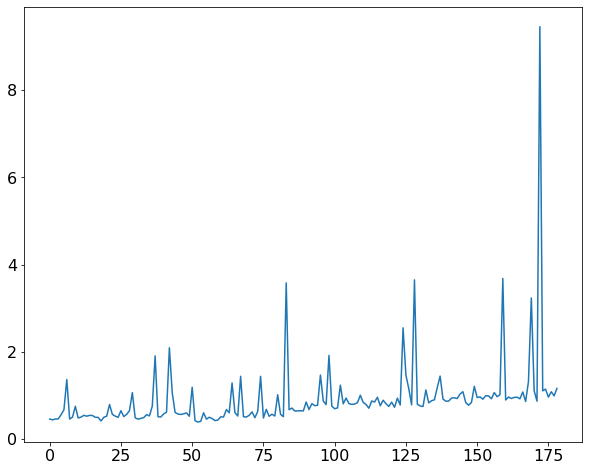

sample: 100%|█████████████████████████████████████████████████████████████| 3000/3000 [00:03<00:00, 778.48it/s, 31 steps of size 1.62e-01. acc. prob=0.68]



                  mean       std    median      5.0%     95.0%     n_eff     r_hat
       mu[0]     -0.37      0.08     -0.40     -0.45     -0.24     37.89      1.07
       mu[1]     -0.23      0.04     -0.23     -0.30     -0.18     15.42      1.08
       mu[2]     -0.19      0.02     -0.19     -0.22     -0.15    450.83      1.00
       mu[3]     -0.15      0.05     -0.15     -0.23     -0.07     96.62      1.01
       mu[4]     -0.08      0.03     -0.07     -0.12     -0.03    208.28      1.00
       mu[5]     -0.04      0.02     -0.04     -0.06     -0.01    427.40      1.00
       mu[6]     -0.02      0.04     -0.03     -0.06      0.05    149.77      1.01
     mu_step      0.19      0.08      0.17      0.07      0.29    133.00      1.00
    sigma[0]     -0.78      0.69     -0.70     -1.90      0.12     17.84      1.09
    sigma[1]     -0.71      0.51     -0.68     -1.54      0.10    715.22      1.00
    sigma[2]     -0.87      0.63     -0.87     -1.97      0.20    596.57      1.00
   

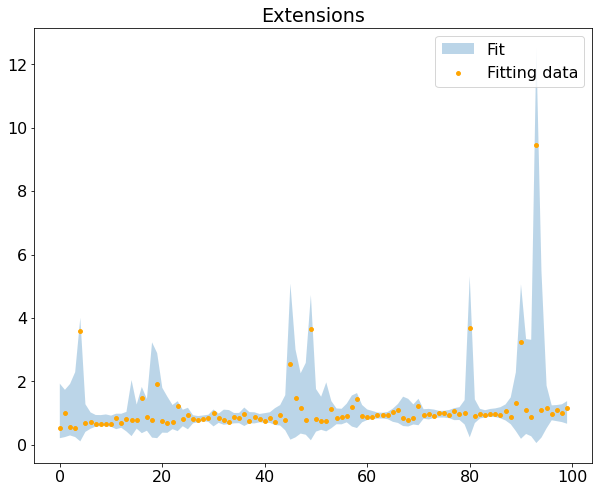

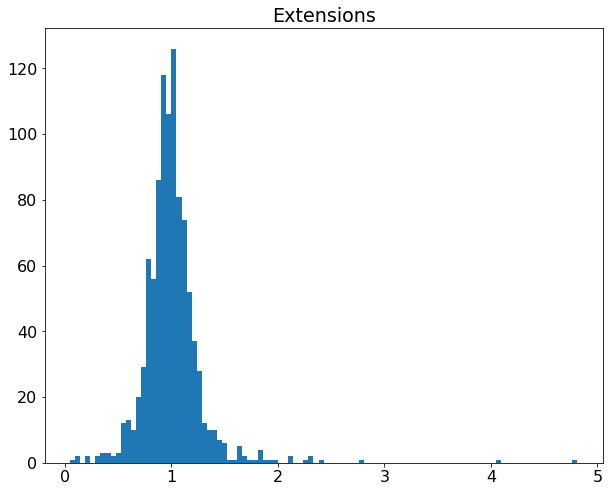

In [17]:
df_renewal_rate['Extend_32GiB_sectors'].plot();plt.show()

x = df_renewal_rate.index.values[-100:]
y = df_renewal_rate['Extend_32GiB_sectors'].values[-100:]

numpyro.render_model(model2, model_args=(x,y,), render_distributions=True)

mcmc, predictions_extend = run_model(x,y)      
plt_posteriors(predictions_extend, title="Extensions")
# plt_posterior_param(mcmc)

### Expirations

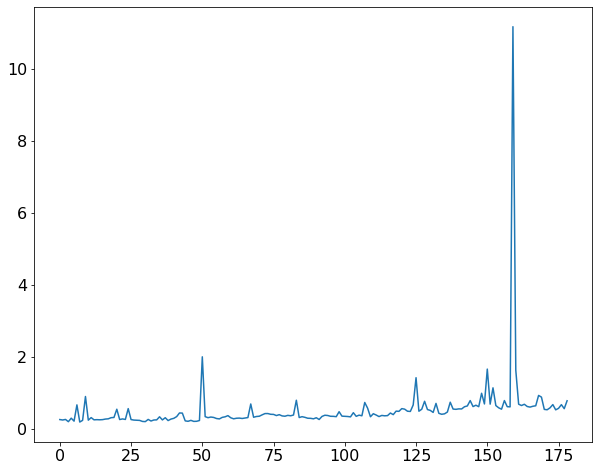

sample: 100%|█████████████████████████████████████████████████████████████| 3000/3000 [00:03<00:00, 764.19it/s, 15 steps of size 2.20e-01. acc. prob=0.83]



                  mean       std    median      5.0%     95.0%     n_eff     r_hat
       mu[0]     -1.16      0.05     -1.17     -1.24     -1.09    489.45      1.00
       mu[1]     -1.02      0.03     -1.02     -1.06     -0.98    486.35      1.00
       mu[2]     -0.90      0.07     -0.92     -1.01     -0.80    249.13      1.00
       mu[3]     -0.64      0.06     -0.64     -0.74     -0.53    620.47      1.00
       mu[4]     -0.52      0.06     -0.52     -0.60     -0.43    382.41      1.00
       mu[5]     -0.37      0.09     -0.38     -0.52     -0.23    294.37      1.00
       mu[6]     -0.47      0.04     -0.47     -0.53     -0.41    396.44      1.01
     mu_step      0.55      0.18      0.51      0.31      0.78    803.12      1.00
    sigma[0]     -0.62      0.50     -0.61     -1.40      0.19    498.28      1.00
    sigma[1]     -0.92      0.57     -0.91     -1.86     -0.02    462.08      1.00
    sigma[2]     -1.04      0.58     -1.02     -1.98     -0.13    460.22      1.00
   

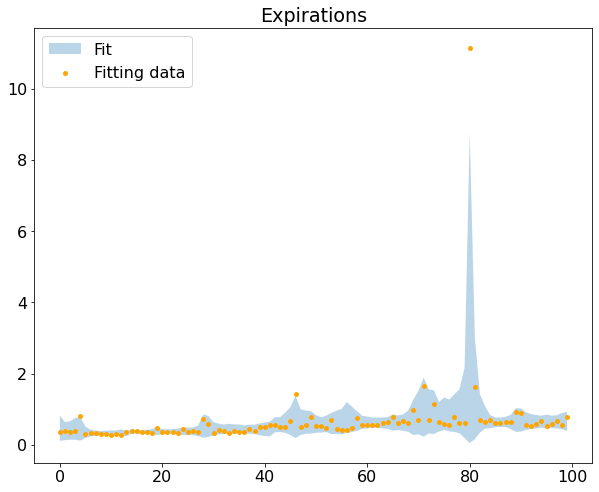

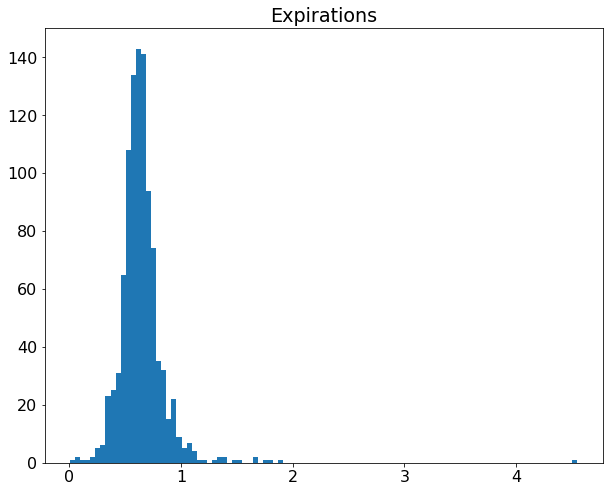

In [18]:
df_renewal_rate['Expired_32GiB_sectors'].plot();plt.show()

x = df_renewal_rate.index.values[-100:]
y = df_renewal_rate['Expired_32GiB_sectors'].values[-100:]

mcmc, predictions_expire = run_model(x,y)      
plt_posteriors(predictions_expire, title="Expirations")
# plt_posterior_param(mcmc)

### Terminations

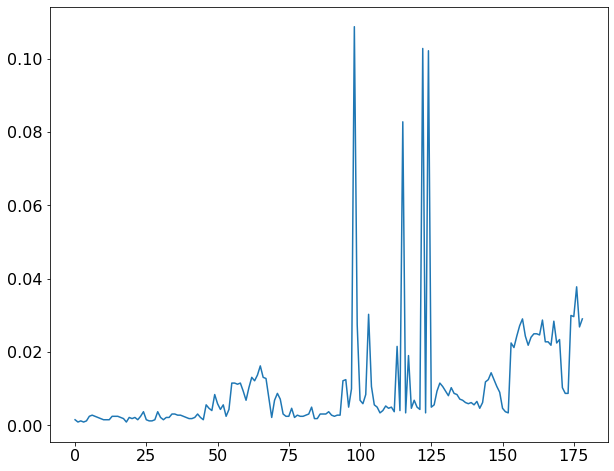

sample: 100%|█████████████████████████████████████████████████████████████| 3000/3000 [00:03<00:00, 791.08it/s, 15 steps of size 2.25e-01. acc. prob=0.87]



                  mean       std    median      5.0%     95.0%     n_eff     r_hat
       mu[0]     -5.82      0.07     -5.82     -5.95     -5.72    651.50      1.00
       mu[1]     -4.91      0.22     -4.91     -5.25     -4.55    527.12      1.00
       mu[2]     -5.34      0.12     -5.34     -5.55     -5.16    374.10      1.00
       mu[3]     -4.70      0.06     -4.70     -4.81     -4.61    695.87      1.00
       mu[4]     -5.05      0.05     -5.06     -5.13     -4.97    515.88      1.00
       mu[5]     -3.71      0.03     -3.71     -3.76     -3.65    668.04      1.01
       mu[6]     -3.69      0.06     -3.70     -3.78     -3.59    321.58      1.00
     mu_step      2.32      0.64      2.20      1.39      3.17    933.81      1.00
    sigma[0]     -0.67      0.51     -0.68     -1.50      0.12    476.56      1.00
    sigma[1]     -1.10      0.59     -1.09     -2.05     -0.16    420.46      1.00
    sigma[2]     -1.32      0.65     -1.30     -2.37     -0.24    503.99      1.00
   

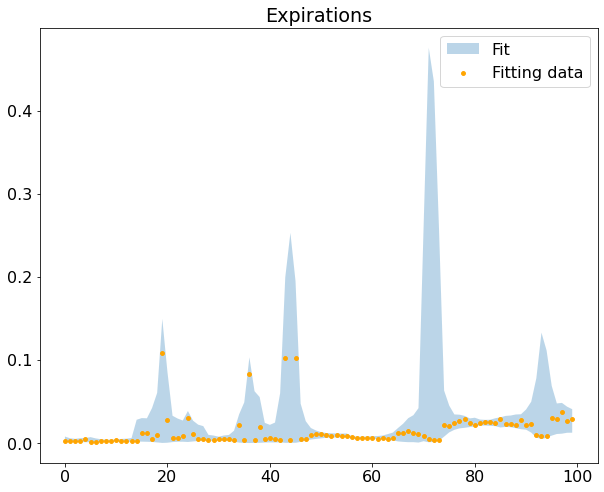

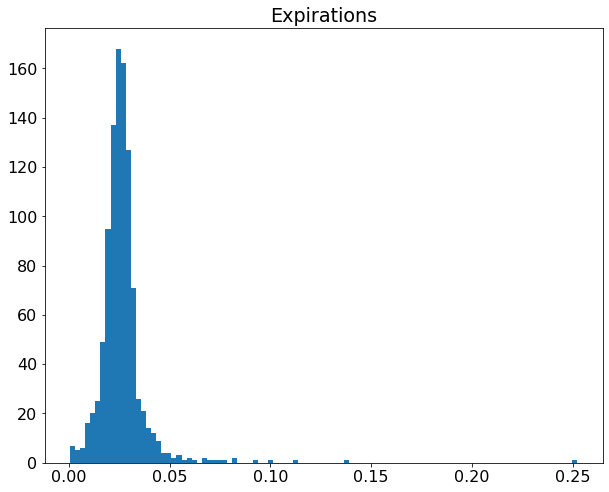

In [19]:
df_renewal_rate['Terminate_32GiB_sectors'].plot();plt.show()

x = df_renewal_rate.index.values[-100:]
y = df_renewal_rate['Terminate_32GiB_sectors'].values[-100:]

mcmc, predictions_term = run_model(x,y)      
plt_posteriors(predictions_term, title="Expirations")
# plt_posterior_param(mcmc)

In [20]:
renewal_dist = predictions_extend[:,-1] / (predictions_extend[:,-1] + predictions_expire[:,-1] + predictions_term[:,-1])

<AxesSubplot:ylabel='Density'>

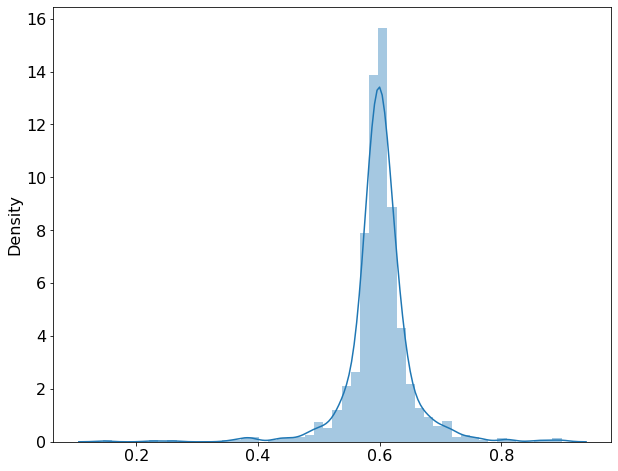

In [21]:
sns.distplot(renewal_dist)

#  Onboarding

Text(0.5, 1.0, 'RBP onboard (PiB)')

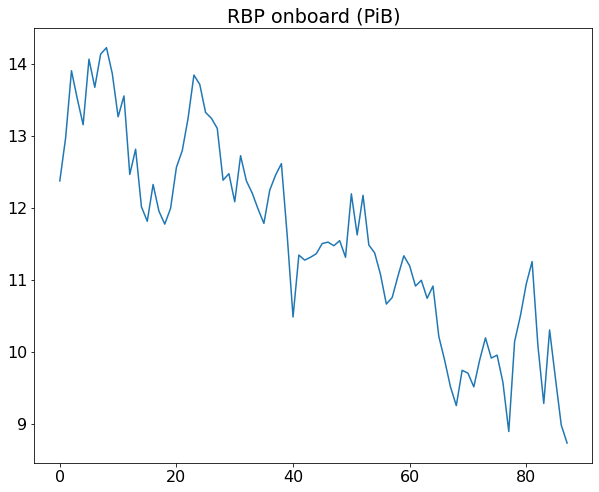

In [22]:
df_onboarding_orig = pd.read_csv('offline_info/Sector_Onboarding_Breakdown_by_Sector_Size.csv')
df_onboarding = df_onboarding_orig.copy()
df_onboarding = df_onboarding[df_onboarding.stateTime <= today]
df_onboarding.Total.plot(); plt.title('RBP onboard (PiB)')

sample: 100%|█████████████████████████████████████████████████████████████| 3000/3000 [00:03<00:00, 806.37it/s, 31 steps of size 2.04e-01. acc. prob=0.85]



                  mean       std    median      5.0%     95.0%     n_eff     r_hat
       mu[0]      2.62      0.02      2.62      2.59      2.64    681.88      1.00
       mu[1]      2.57      0.02      2.58      2.54      2.60    171.45      1.03
       mu[2]      2.51      0.01      2.51      2.49      2.52    379.04      1.00
       mu[3]      2.44      0.01      2.44      2.43      2.45    553.64      1.00
       mu[4]      2.38      0.01      2.38      2.36      2.40    222.69      1.01
       mu[5]      2.29      0.01      2.29      2.27      2.31    602.51      1.00
     mu_step      1.18      0.37      1.11      0.66      1.69    641.18      1.00
    sigma[0]     -1.16      0.51     -1.14     -2.07     -0.40    409.38      1.00
    sigma[1]     -2.02      0.59     -1.99     -3.06     -1.15    302.05      1.00
    sigma[2]     -2.64      0.63     -2.64     -3.59     -1.51    285.15      1.00
    sigma[3]     -2.99      0.61     -3.01     -3.84     -1.83    373.63      1.00
   

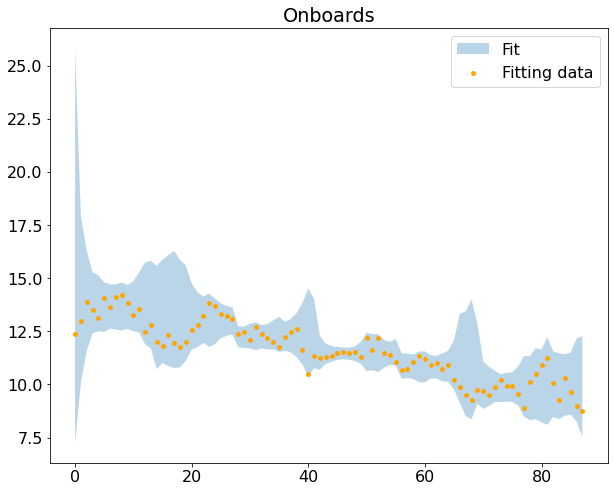

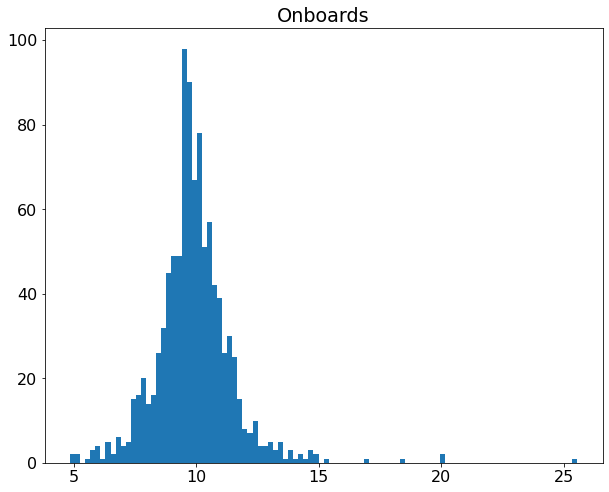

In [24]:
x = df_onboarding.index.values[-100:]
y = df_onboarding['Total'].values[-100:]

mcmc, predictions_onboard = run_model(x,y)      
plt_posteriors(predictions_onboard, title="Onboards")

Text(0.5, 1.0, 'Raw byte onboarding/daily')

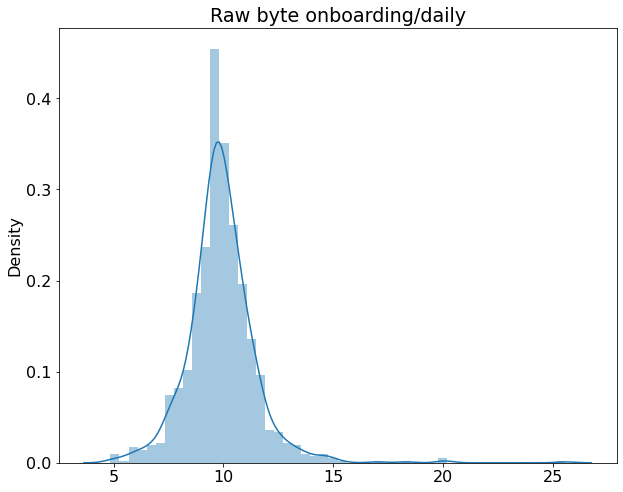

In [25]:
onboarding_dist = predictions_onboard[:,-1]
sns.distplot(onboarding_dist); plt.title('Raw byte onboarding/daily')

### FIL+ rate

Text(0.5, 1.0, 'Deals onboard (PiB)')

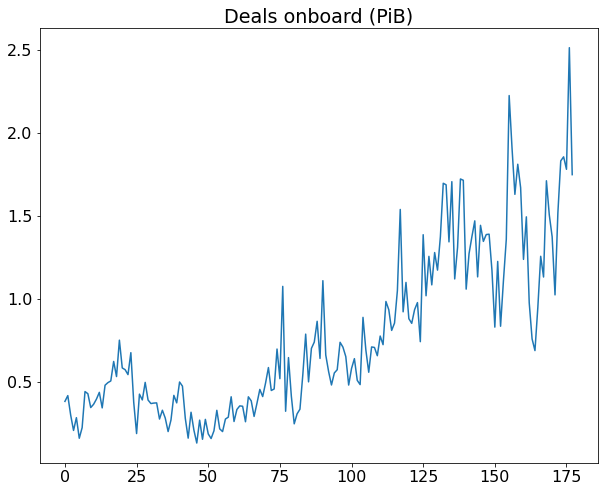

In [44]:
df_deals_orig = pd.read_csv('offline_info/Daily_Active_Deal_TiB_Change_Breakdown.csv')
df_deals = df_deals_orig.copy()
df_deals['deals_onboard'] = df_deals['New Active Deal'] / 1024
df_deals = df_deals[df_deals.stateTime <= today]
df_deals.deals_onboard.plot(); plt.title('Deals onboard (PiB)')

In [36]:
df_deals.index.values[-80:]
df_deals.deals_onboard.values[-80:]

array([1.31, 1.07, 1.02, 1.45, 1.14, 0.95, 1.34, 1.31, 1.19, 1.23, 1.33,
       1.33, 1.26, 1.34, 1.63, 1.68, 1.63, 1.46, 1.71, 2.36, 1.9 , 2.  ,
       1.78, 1.52, 1.81, 1.79, 1.93, 2.01, 2.24, 2.08, 2.02, 2.3 , 2.22,
       2.34, 2.93, 2.88, 3.18, 3.07, 2.54, 2.48, 2.8 , 2.94, 2.21, 2.28,
       2.61, 2.56, 2.59, 2.44, 2.87, 2.41, 2.58, 2.3 , 1.78, 2.08, 1.84,
       1.99, 2.67, 3.36, 3.86, 3.22, 3.37, 2.98, 2.35, 2.69, 2.04, 1.53,
       1.45, 1.46, 2.07, 2.36, 2.7 , 2.9 , 3.14, 2.3 , 2.23, 2.58, 3.49,
       3.3 , 3.76, 3.73])

sample: 100%|█████████████████████████████████████████████████| 3000/3000 [00:04<00:00, 745.94it/s, 31 steps of size 1.45e-01. acc. prob=0.91]



                  mean       std    median      5.0%     95.0%     n_eff     r_hat
       mu[0]     -0.35      0.05     -0.35     -0.44     -0.26    870.99      1.00
       mu[1]     -0.04      0.05     -0.05     -0.13      0.03   1102.98      1.00
       mu[2]      0.31      0.07      0.31      0.21      0.42    757.88      1.00
       mu[3]      0.23      0.06      0.24      0.15      0.33    610.79      1.01
       mu[4]      0.43      0.07      0.43      0.30      0.55    535.70      1.00
     mu_step      0.37      0.16      0.33      0.17      0.57    913.31      1.00
    sigma[0]     -0.34      0.28     -0.34     -0.82      0.10    571.75      1.00
    sigma[1]     -0.60      0.34     -0.59     -1.16     -0.07    583.42      1.00
    sigma[2]     -0.82      0.39     -0.81     -1.44     -0.14    480.65      1.00
    sigma[3]     -0.98      0.37     -0.97     -1.59     -0.37    477.97      1.01
    sigma[4]     -1.08      0.34     -1.08     -1.64     -0.56    477.56      1.01
   

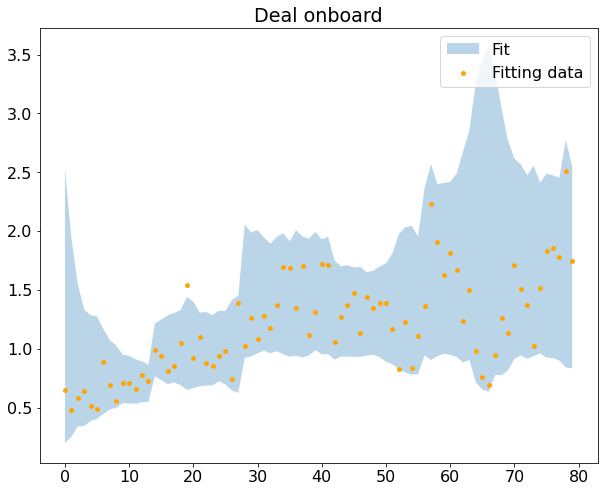

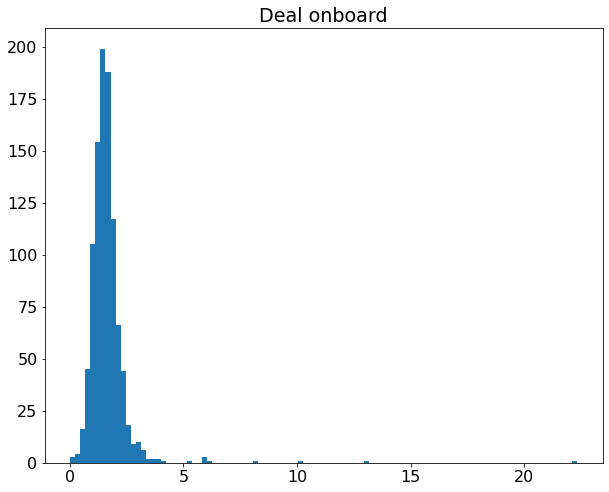

In [45]:
x = df_deals.index.values[-80:]
y = df_deals.deals_onboard.values[-80:]

mcmc, predictions_deal = run_model(x,y,14)      
plt_posteriors(predictions_deal, title="Deal onboard")

In [46]:
predictions_onboard[:,-1].mean(), (np.array((predictions_deal[:,-1] / 10))).mean()

(DeviceArray(9.901461, dtype=float32), 0.16439237)

In [47]:
fil_plus_rate = (np.array((predictions_deal[:,-1]))) / np.array(predictions_onboard[:,-1])
fil_plus_rate[fil_plus_rate > 1] = 1

(0.0, 1.0)

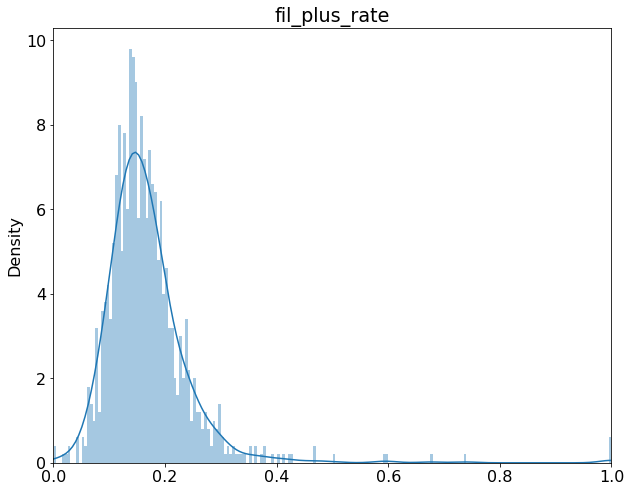

In [48]:
sns.distplot(fil_plus_rate,bins=200); plt.title('fil_plus_rate');plt.xlim(0,1)

In [49]:
df_dist = pd.DataFrame({'rb_onboard_power' : onboarding_dist,
              'renewal_rate' : renewal_dist,
              'fil_plus_rate': fil_plus_rate})
df_dist.head()

,rb_onboard_power,renewal_rate,fil_plus_rate
0,8.943283,0.589401,0.140537
1,9.725459,0.619321,0.270865
2,9.647730,0.612062,0.116657
3,10.542575,0.644234,0.127858
4,9.948843,0.616875,0.125688


In [50]:
df_dist.to_csv('./offline_info/df_distributions_for_power_model_parameters.csv')